# Initial attempt to learn from SF data

We use only part of the data (exp22-24) and a basic algorithm (Ridge regression)

In [1]:
import sys
import os

import numpy as np
import pandas as pd
import sqlite3
from rdkit import Chem
from rdkit.Chem.Descriptors import rdMolDescriptors
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from matplotlib import cm

sys.path.insert(0, os.path.abspath('../..'))

from src.definitions import DB_PATH
from src.util.db_utils import MyDatabaseConnection

In [2]:
db = MyDatabaseConnection()  # we will use this for various simple queries

In [3]:
con = sqlite3.connect(DB_PATH)
df_full = pd.read_sql('SELECT * FROM experiments', con, index_col='id', coerce_float=False)
con.close()
print(f'Number of reactions (in total): {len(df_full)}')

Number of reactions (in total): 58664


In [4]:
# select experiment numbers for further analysis
start_exp_nr = 14
end_exp_nr = 27  # (inclusive)

df_full = df_full.loc[df_full['exp_nr'].between(start_exp_nr, end_exp_nr)]  # kick out invalid experiments (SOP changed after exp3)
df_full = df_full.loc[~(df_full['lab_journal_number'] == "JG335")]
                      
print(f'Number of reactions considered here: {len(df_full)}')

Number of reactions considered here: 26560


In [5]:
descriptor_names = list(rdMolDescriptors.Properties.GetAvailableProperties())

get_descriptors = rdMolDescriptors.Properties(descriptor_names)

def smi_to_descriptors(smile):
    mol = Chem.MolFromSmiles(smile)
    descriptors = []
    if mol:
        descriptors = np.array(get_descriptors.ComputeProperties(mol))
    return descriptors

In [6]:
df_full['descriptors'] = df_full["product_A_smiles"].apply(smi_to_descriptors)

In [7]:
df_full

,exp_nr,plate_nr,well,lab_journal_number,synthesis_date_unixepoch,initiator,monomer,terminator,initiator_long,monomer_long,...,product_B_smiles,product_C_smiles,product_D_smiles,product_E_smiles,product_F_smiles,product_G_smiles,product_H_smiles,vl_id,valid,descriptors
id,,,,,,,,,,,,,,,,,,,,,
33682,14,4,A10,JG312,2022-03-29,I67,M11,T41,Ph023,Mon003,...,CC(C)C[C@@H](CC1(C(=O)O)NN=C(c2cccnc2)S1)NC(=O...,CC(C)C[C@H]1CC2(C(=O)[O-])SC(c3cccnc3)=N[N+]2=...,Clc1ccc(-c2nnc(-c3cccnc3)s2)cc1,c1cncc(-c2nnc(-c3cccnc3)s2)c1,CC(C)C[C@@H](CC(=O)C(=O)O)NC(=O)c1ccc(Cl)cc1,CC(C)C[C@@H](CC(=O)O)NC(=O)c1ccc(Cl)cc1,CC(C)CC=Cc1nnc(-c2cccnc2)s1,200695,ERROR: too many peaks for IS (2),"[400.112459972, 400.9350000000002, 5.0, 1.0, 7..."
33683,14,4,A11,JG312,2022-03-29,I67,M11,T9,Ph023,Mon003,...,CC(C)C[C@@H](CC1(C(=O)O)Nc2ccc(S(C)(=O)=O)cc2S...,CC(C)C[C@H]1CC2(C(=O)[O-])Sc3cc(S(C)(=O)=O)ccc...,CS(=O)(=O)c1ccc2nc(-c3ccc(Cl)cc3)sc2c1,CS(=O)(=O)c1ccc(N)c(SSc2cc(S(C)(=O)=O)ccc2N)c1,CC(C)C[C@@H](CC(=O)C(=O)O)NC(=O)c1ccc(Cl)cc1,CC(C)C[C@@H](CC(=O)O)NC(=O)c1ccc(Cl)cc1,CC(C)CC=Cc1nc2ccc(S(C)(=O)=O)cc2s1,200663,None,"[450.083862276, 451.01300000000015, 5.0, 1.0, ..."
33684,14,4,A12,JG312,2022-03-29,I67,M11,T37,Ph023,Mon003,...,CC(C)C[C@@H](CC1(C(=O)O)NN=C(c2cccc3[nH]ncc23)...,CC(C)C[C@H]1CC2(C(=O)[O-])SC(c3cccc4[nH]ncc34)...,Clc1ccc(-c2nnc(-c3cccc4[nH]ncc34)s2)cc1,c1cc(-c2nnc(-c3cccc4[nH]ncc34)s2)c2cn[nH]c2c1,CC(C)C[C@@H](CC(=O)C(=O)O)NC(=O)c1ccc(Cl)cc1,CC(C)C[C@@H](CC(=O)O)NC(=O)c1ccc(Cl)cc1,CC(C)CC=Cc1nnc(-c2cccc3[nH]ncc23)s1,200691,None,"[439.123359004, 439.9720000000001, 6.0, 2.0, 7..."
33685,14,4,A13,JG312,2022-03-29,I67,M64,T4,Ph023,Spiro006,...,Cc1cc2c(cc1C)SC(C(=O)O)(C1(CNC(=O)c3ccc(Cl)cc3...,Cc1cc2c(cc1C)[N+]1=C(c3ccc(Cl)cc3)NCC3(CCN(C(=...,Cc1cc2nc(-c3ccc(Cl)cc3)sc2cc1C,Cc1cc(N)c(SSc2cc(C)c(C)cc2N)cc1C,O=C(O)C(=O)C1(CNC(=O)c2ccc(Cl)cc2)CCN(C(=O)OCc...,O=C(NCC1(C(=O)O)CCN(C(=O)OCc2ccccc2)CC1)c1ccc(...,O,202831,None,"[547.1696405, 548.1080000000004, 6.0, 1.0, 6.0..."
33686,14,4,A14,JG312,2022-03-29,I67,M64,T10,Ph023,Spiro006,...,O=C(NCC1(C2(C(=O)O)Nc3cc(Cl)ccc3S2)CCN(C(=O)OC...,O=C(OCc1ccccc1)N1CCC2(CC1)CNC(c1ccc(Cl)cc1)=[N...,Clc1ccc(-c2nc3cc(Cl)ccc3s2)cc1,Nc1cc(Cl)ccc1SSc1ccc(Cl)cc1N,O=C(O)C(=O)C1(CNC(=O)c2ccc(Cl)cc2)CCN(C(=O)OCc...,O=C(NCC1(C(=O)O)CCN(C(=O)OCc2ccccc2)CC1)c1ccc(...,O,202837,None,"[553.0993680199999, 554.4990000000004, 6.0, 1...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73997,14,3,P5,JG311,2022-03-29,I57,M60,T14,Ph007,Spiro003,...,COc1ccc(C(=O)NCC2(C3(C(=O)O)Nc4cc(OC)c(OC)cc4S...,COc1ccc(C2=[N+]3c4cc(OC)c(OC)cc4SC3(C(=O)[O-])...,COc1ccc(-c2nc3cc(OC)c(OC)cc3s2)c(OC)c1,COc1cc(N)c(SSc2cc(OC)c(OC)cc2N)cc1OC,COc1ccc(C(=O)NCC2(C(=O)C(=O)O)CCN(C(=O)OCC3CCC...,COc1ccc(C(=O)NCC2(C(=O)O)CCN(C(=O)OCC3CCC3)CC2...,O,172378,None,"[583.2352215239999, 583.7070000000003, 10.0, 1..."
73998,14,3,P6,JG311,2022-03-29,I57,M60,T6,Ph007,Spiro003,...,COc1ccc(C(=O)NCC2(C3(C(=O)O)Nc4ccc(OC(F)(F)F)c...,COc1ccc(C2=[N+]3c4ccc(OC(F)(F)F)cc4SC3(C(=O)[O...,COc1ccc(-c2nc3ccc(OC(F)(F)F)cc3s2)c(OC)c1,Nc1ccc(OC(F)(F)F)cc1SSc1cc(OC(F)(F)F)ccc1N,COc1ccc(C(=O)NCC2(C(=O)C(=O)O)CCN(C(=O)OCC3CCC...,COc1ccc(C(=O)NCC2(C(=O)O)CCN(C(=O)OCC3CCC3)CC2...,O,172370,None,"[607.1963914040001, 607.6510000000001, 9.0, 1...."
73999,14,3,P7,JG311,2022-03-29,I57,M60,T15,Ph007,Spiro003,...,COc1ccc(C(=O)NCC2(C3(C(=O)O)Nc4ccc(Br)cc4S3)CC...,COc1ccc(C2=[N+]3c4ccc(Br)cc4SC3(C(=O)[O-])C3(C...,COc1ccc(-c2nc3ccc(Br)cc3s2)c(OC)c1,Nc1ccc(Br)cc1SSc1cc(Br)ccc1N,COc1ccc(C(=O)NCC2(C(=O)C(=O)O)CCN(C(=O)OCC3CCC...,COc1ccc(C(=O)NCC2(C(=O)O)CCN(C(=O)OCC3CCC3)CC2...,O,172379,None,"[601.1246042240001, 602.5510000000002, 8.0, 1...."


In [8]:
df_full[df_full["product_A_lcms_ratio"].isna()]

,exp_nr,plate_nr,well,lab_journal_number,synthesis_date_unixepoch,initiator,monomer,terminator,initiator_long,monomer_long,...,product_B_smiles,product_C_smiles,product_D_smiles,product_E_smiles,product_F_smiles,product_G_smiles,product_H_smiles,vl_id,valid,descriptors
id,,,,,,,,,,,,,,,,,,,,,


In [9]:
# extract our data
X = np.stack(df_full["descriptors"].values.tolist())
y = df_full["product_A_lcms_ratio"].values

In [10]:
X.shape

(26560, 43)

In [11]:
y.shape

(26560,)

In [12]:
y = y.reshape(-1,1)
y.shape

(26560, 1)

In [13]:
# normalize y to 0-100
y = (y - y.min()) / (y.max() - y.min()) * 100

In [52]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1)

In [53]:
# scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [54]:
# hparam search
val_scores = []
alphas = np.logspace(-7, 1, num=1000)
for alpha in alphas:
    model = Ridge(alpha=alpha)
    model.fit(X_train, y_train)
    y_hat = model.predict(X_val)
    val_scores.append(mean_absolute_error(y_val, y_hat))

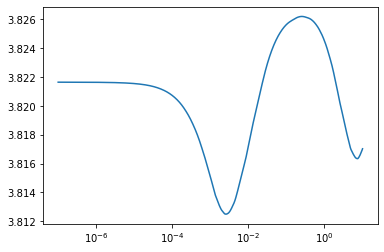

In [55]:
# show hparam search results
plt.plot(alphas, val_scores)
plt.xscale("log")
plt.show()

In [56]:
# best alpha
best_alpha = alphas[np.argmin(val_scores)]
print(best_alpha)

0.002584713507469564


In [57]:
best_alpha = 0.005

In [58]:
# fit model on test set with best hparams
model = Ridge(alpha=best_alpha)
model.fit(np.concatenate((X_train, X_val)), np.concatenate((y_train, y_val)))
y_hat = model.predict(X_test)

print(f"MAE: {mean_absolute_error(y_test, y_hat)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_hat))}")

MAE: 3.718463997976009
RMSE: 6.422615342462785


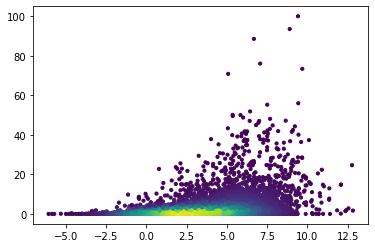

In [59]:
from scipy.stats import gaussian_kde
# Calculate the point density
xy = np.vstack([y_hat.flatten(),y_test.flatten()])
z = gaussian_kde(xy)(xy)


fig, ax = plt.subplots()
ax.scatter(y_hat, y_test, c=z,  s=10)
plt.show()


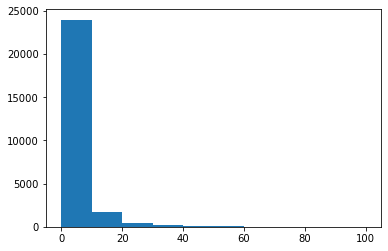

In [60]:
# the distribution of y is not good for learning
plt.figure()
plt.hist(y)
plt.show()

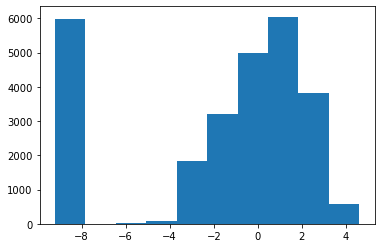

In [61]:
# the logarithm is much better behaved
plt.figure()
plt.hist(np.log(y+0.0001))
plt.show()

In [68]:
y_test

array([[2.02515136],
       [0.1989897 ],
       [3.36831049],
       ...,
       [3.69740268],
       [1.70922835],
       [0.        ]])

In [62]:
# hparam search
val_scores = []
alphas = np.logspace(-7, 1, num=1000)
for alpha in alphas:
    model = Ridge(alpha=alpha)
    model.fit(X_train, y_train_log)
    y_hat = model.predict(X_val)
    val_scores.append(mean_absolute_error(y_val_log, y_hat))

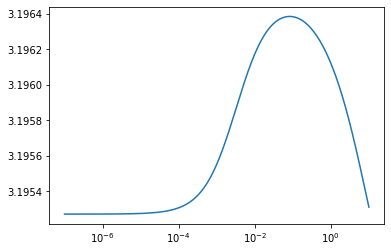

In [63]:
# show hparam search results
plt.plot(alphas, val_scores)
plt.xscale("log")
plt.show()

In [65]:
# best alpha
best_alpha = alphas[np.argmin(val_scores)]
print(best_alpha)

1e-07


In [66]:
# fit model on test set with best hparams
model = Ridge(alpha=best_alpha)
model.fit(np.concatenate((X_train, X_val)), np.concatenate((y_train_log, y_val_log)))
y_hat = model.predict(X_test)

print(f"MAE: {mean_absolute_error(y_test_log, y_hat)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_log, y_hat))}")

MAE: 3.2447974464527283
RMSE: 3.892648943910121


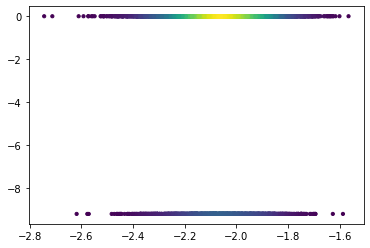

In [67]:
from scipy.stats import gaussian_kde
# Calculate the point density
xy = np.vstack([y_hat.flatten(),y_test_log.flatten()])
z = gaussian_kde(xy)(xy)


fig, ax = plt.subplots()
ax.scatter(y_hat, y_test_log, c=z,  s=10)
plt.show()


In [22]:
# get highest coefficients
highest_coefs = np.argsort(np.abs(model.coef_.flatten()))[::-1]

In [23]:
# show most extreme coefficients with their names
for idx in highest_coefs[:5]:
    print(descriptor_names[idx])
    print(model.coef_.flatten()[idx])

amw
-449.003530346223
exactmw
432.2800680085848
chi0v
81.48794750007929
chi0n
-40.46313577840624
labuteASA
-28.681531741780947


In [24]:
# helper function
def iterable_to_nested_list(list_to_break_up, inner_len, pad_last=False, pad_value=None):
    """Break up list into nested lists of given length"""
    # invert list for fast pop()
    list_tmp = list(reversed(list_to_break_up))

    outer_list = []
    while len(list_tmp) > 0:
        inner_list = []
        while len(inner_list) < inner_len:
            if len(list_tmp) == 0:
                if pad_last:
                    while len(inner_list) < inner_len:
                        inner_list.append(pad_value)
                break
            inner_list.append(list_tmp.pop())
        outer_list.append(inner_list)
    return outer_list

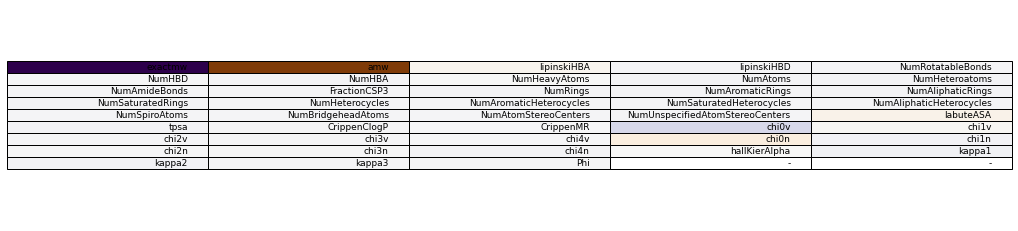

In [25]:
# show most extreme descriptors
fig, ax = plt.subplots(figsize=(18,4))
ax.axis('tight')
ax.axis('off')

norm = plt.Normalize()
colors = iterable_to_nested_list(cm.PuOr(norm(model.coef_.flatten())), 5,True,  np.array([1.,1.,1.,1.]))

ax.table(cellText = iterable_to_nested_list(descriptor_names, 5, True, "-"), cellColours=colors, loc='center')
plt.show()

(array([   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0., 5995.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.]),
 array([-0.5 , -0.49, -0.48, -0.47, -0.46, -0.45, -0.44, -0.43, -0.42,
        -0.41, -0.4 , -0.39, -0.38, -0.37, -0.36, -0.35, -0.34, -0.33,
        -0.32, -0.31, -0.3 , -0.29, -0.28, -0.27, -0.26, -0.

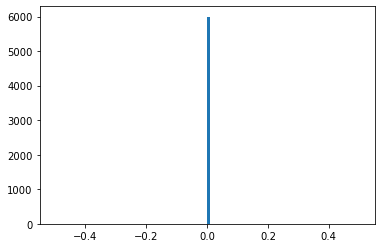

In [26]:
# where should we put the classification threshold?
plt.hist(y[y<0.001], bins=100)

In [27]:
# bin y into two clases
y_binary = np.zeros(len(y))
y_binary[y.flatten()>0.001] = 1.
y_binary

array([1., 0., 1., ..., 0., 1., 1.])

In [28]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1)

In [29]:
# scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [30]:
val_scores = []
Cs = np.logspace(-3, 4, num=100)
for C in Cs:
    model = LogisticRegression(C=C, solver="liblinear")
    model.fit(X_train, y_train)
    y_hat = model.predict(X_val)
    val_scores.append(accuracy_score(y_val, y_hat))

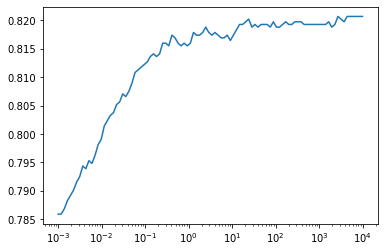

In [31]:
# show hparam search results
plt.plot(Cs, val_scores)
plt.xscale("log")
plt.show()

In [32]:
np.count_nonzero(y) / len(y)

0.7742846385542169